In [34]:
import warnings

# Ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import scanpy as sc
import scvi

In [35]:
adata = sc.read_h5ad("1_qc.h5ad")
adata

AnnData object with n_obs × n_vars = 9535 × 27521
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'ambiguous', 'count', 'log1p', 'spliced', 'unspliced'

In [36]:
# Specify which colorings to use for plotting
umap_colorings = [
    "sample",
    "cell_type",
]

# Data preparation

In [37]:
# For now, we ignore RR cells
# They have a different gene expression profile
# Not sure how to deal with them yet (and what we want to learn from them)
adata = adata[~adata.obs["is_rr"]].copy()

# Identify highly variable genes
# Using 5000 genes for now, can be adjusted
sc.pp.highly_variable_genes(adata, n_top_genes=5000, batch_key="sample", layer="log1p")
adata_hvg = adata[:, adata.var.highly_variable].copy()

## Looking at the uncorrected data distributions

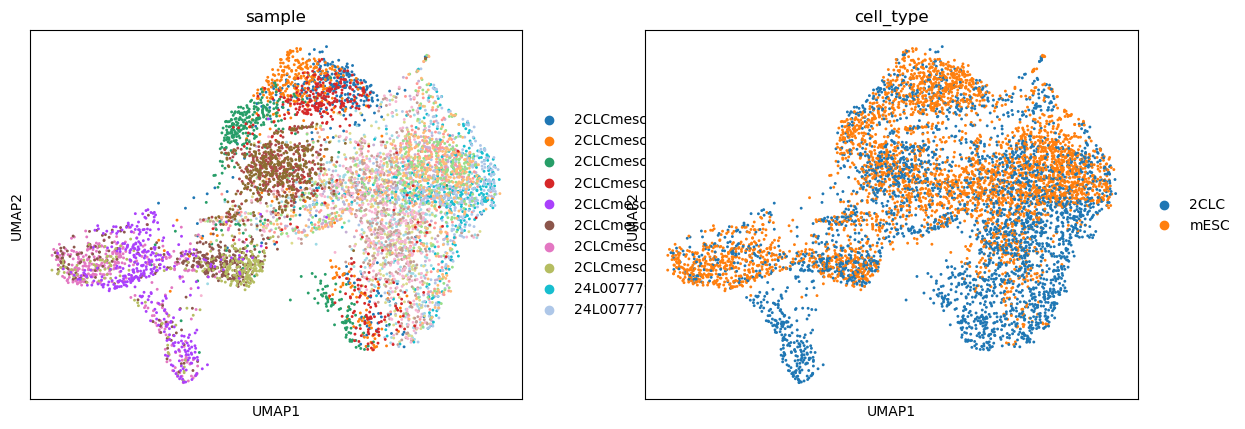

In [38]:
sc.pp.pca(adata, n_comps=50, layer="log1p")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=umap_colorings,
)

We can see that the samples form clusters in the UMAP. This indicates that the batch effects are not negligible.
We can also see that the cell types separate in the UMAP. 
Biological signal and batch effects appear to be of similar strength in this data.

# Integration

Batch correction is referred to as integration in the single-cell literature. This is, because the count matrices are too large for performing actual batch correction. Instead, the data is integrated into a lower-dimensional space, where the batch effects are removed.

## scVI

scVI uses a variational Autoencoder to integrate the data. The encoder learns a lower-dimensional representation of the data, while the decoder learns to reconstruct the data from this representation.

In [40]:
# Create and train the model
scvi.model.SCVI.setup_anndata(adata_hvg, batch_key="sample", layer="count")
model = scvi.model.SCVI(adata_hvg)
model.train(max_epochs=400, accelerator='cuda')

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


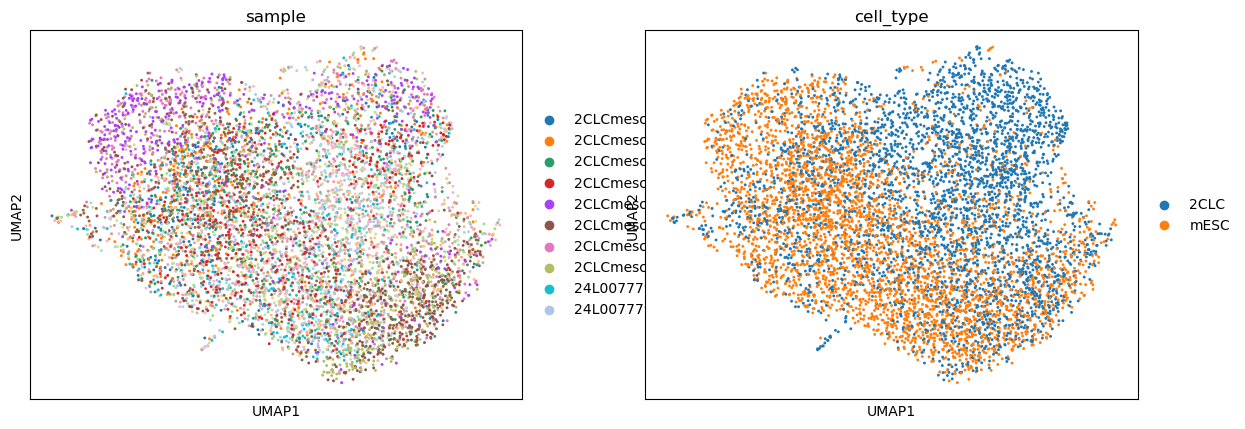

In [41]:
# Extract the latent space and store it in the anndata object
adata.obsm["X_scvi"] = model.get_latent_representation()

# Plot the UMAP based on the scVI latent space
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=umap_colorings,
)

While the cell types still separate in the UMAP, the batch effects are removed. This indicates that scVI has successfully integrated the data.
However it looks overcorrected, as subpopulations are not as clearly separated as in the uncorrected data.

In [42]:
# Save the UMAP coordinates to a permanent location
adata.obsm["X_umap_scvi"] = adata.obsm["X_umap"].copy()

## Harmony

Harmony receives a PCA representation of the data and removes the batch effects from there.
Benchmarks have shown that Harmony is one of the best batch correction methods for single-cell data.

In [43]:
# Usually converges after 10-20 iterations
sc.external.pp.harmony_integrate(adata, "sample", max_iter_harmony=20)

2025-01-12 12:07:48,855 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-12 12:07:49,494 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-12 12:07:49,521 - harmonypy - INFO - Iteration 1 of 20
2025-01-12 12:07:51,395 - harmonypy - INFO - Iteration 2 of 20
2025-01-12 12:07:53,406 - harmonypy - INFO - Iteration 3 of 20
2025-01-12 12:07:55,243 - harmonypy - INFO - Iteration 4 of 20
2025-01-12 12:07:56,765 - harmonypy - INFO - Iteration 5 of 20
2025-01-12 12:07:58,759 - harmonypy - INFO - Iteration 6 of 20
2025-01-12 12:07:59,824 - harmonypy - INFO - Iteration 7 of 20
2025-01-12 12:08:00,915 - harmonypy - INFO - Iteration 8 of 20
2025-01-12 12:08:02,142 - harmonypy - INFO - Iteration 9 of 20
2025-01-12 12:08:03,286 - harmonypy - INFO - Iteration 10 of 20
2025-01-12 12:08:04,218 - harmonypy - INFO - Iteration 11 of 20
2025-01-12 12:08:05,465 - harmonypy - INFO - Iteration 12 of 20
2025-01-12 12:08:07,081 - harmonypy - INFO - Iteration 13 of

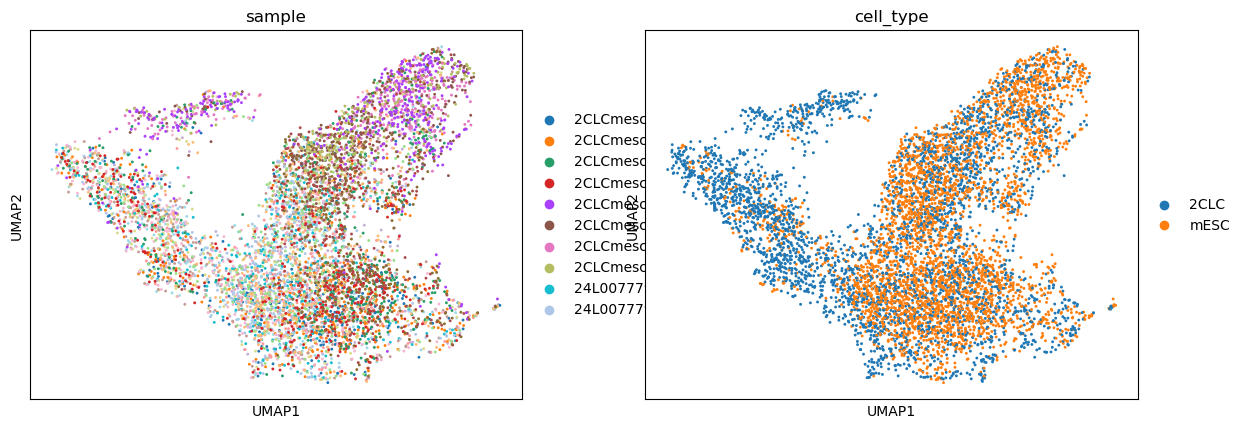

In [44]:
# Again, plot the UMAP based on the batch-corrected PCA computed by Harmony
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=umap_colorings
)

Here, cell types also separate in the UMAP. Some samples are still clustered, but the batch effects are mostly removed.
This is probably a good compromise between removing batch effects and keeping the biological signal.

In [45]:
# Save the UMAP coordinates to a permanent location
adata.obsm["X_umap_harmony"] = adata.obsm["X_umap"].copy()

# Save the data

In [46]:
adata

AnnData object with n_obs × n_vars = 6966 × 27521
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'X_scvi', 'X_umap_scvi', 'X_pca_harmony', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'ambiguous', 'count', 'log1p', 'spliced'

In [47]:
adata.write("2_integrate.h5ad")